# Compare clustering and manual gating in large PBMC panel

In this notebook, we compare the gating results of different experts with the clustering results.

The first question is how well the pre-processing filters for living cells and singlets overlap. We decided that we will assess gating purity only based on the intersection of all filtering results. This way, we ensure that assessing the gating quality is less biased by the pro-processing decisions of each person.

In [17]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import datetime
#import pytometry as pm
import sklearn.metrics 
from upsetplot import plot, UpSet

import os

sc.logging.print_versions()
sc.settings.verbosity = 3 

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
asciitree           NA
asttokens           NA
backcall            0.2.0
cffi                1.15.1
cloudpickle         2.0.0
colorama            0.4.5
cupy                9.6.0
cupy_backends       NA
cupyx               NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.2.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           0.9.1
fasteners           0.17.3
fastrlock           0.8
google              NA
h5py                3.1.0
ipykernel           6.15.1
ipython_genutils    0.2.0
ipywidgets          7.7.1
jedi                0.18.1
jinja2              3.1.2
joblib              1.1.0
jupyter_server      1.18.1
kiwisolver          1.4.4
llvmlite            0.38.1
markupsafe          2.1.1
matplotlib          3.5.3
mpl_toolkits        NA
msgpack             1.0.3
nats

In [18]:
sc.settings.figdir = './../figures/' 

Add date.

In [19]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [20]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 80))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,10))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Read data

In [21]:
data_path = './../data/Convex_gating_test_MB/'

In [22]:
adata_con = sc.read(data_path + 'anndata/' + 'adata_concatenated_manGates.h5ad')

In [23]:
adata_con

AnnData object with n_obs × n_vars = 1444540 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch', 'cell debris', 'cluster cell type lvl 1', 'cluster cell type lvl 2', 'manual cell debris_Gold', 'manual cell debris_p1', 'manual cell debris_p2', 'manual cell debris_p3', 'manual cell debris_p4', 'manual cell debris_p5', 'manual cell debris_p6', 'manual cell debris_p7.1', 'manual cell debris_p7.2', 'manual cell debris_p7.3', 'manual cell debris_p7.4', 'manual cell type lvl 1_Gold', 'manual cell type lvl 1_p1', 'manual cell type lvl 1_p2', 'manual cell type lvl 1_p3', 'manual cell type lvl 1_p4', 'manual cell type lvl 1_p5', 'manual cell type lvl 1_p6', 'manual cell type lvl 1_p7.1', 'manual cell type lvl 1_p7.2', 'manual cell type lvl 1_p7.3', 'manual cell type lvl 1_p7.4', 'manual cell type lvl 2_Gold', 'manual cell type lvl 2_p1', 'manual cell type lvl 2_p2', 'manual cell type lvl 2_p3', 'manual cell type lvl 2_p4', 'manual cell type lvl 2_p5', '

Remove results of submission p7.4 due to gate submission error for one sample.

In [24]:
adata_con.obs.drop(columns=['manual cell type lvl 2_p7.4', 
                            'manual cell type lvl 1_p7.4', 
                            'manual cell debris_p7.4'], inplace=True)

In [25]:
adata_con

AnnData object with n_obs × n_vars = 1444540 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch', 'cell debris', 'cluster cell type lvl 1', 'cluster cell type lvl 2', 'manual cell debris_Gold', 'manual cell debris_p1', 'manual cell debris_p2', 'manual cell debris_p3', 'manual cell debris_p4', 'manual cell debris_p5', 'manual cell debris_p6', 'manual cell debris_p7.1', 'manual cell debris_p7.2', 'manual cell debris_p7.3', 'manual cell type lvl 1_Gold', 'manual cell type lvl 1_p1', 'manual cell type lvl 1_p2', 'manual cell type lvl 1_p3', 'manual cell type lvl 1_p4', 'manual cell type lvl 1_p5', 'manual cell type lvl 1_p6', 'manual cell type lvl 1_p7.1', 'manual cell type lvl 1_p7.2', 'manual cell type lvl 1_p7.3', 'manual cell type lvl 2_Gold', 'manual cell type lvl 2_p1', 'manual cell type lvl 2_p2', 'manual cell type lvl 2_p3', 'manual cell type lvl 2_p4', 'manual cell type lvl 2_p5', 'manual cell type lvl 2_p6', 'manual cell type lvl 2_p7.1',

In [26]:
adata_con.obs.columns

Index(['sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time',
       'batch', 'cell debris', 'cluster cell type lvl 1',
       'cluster cell type lvl 2', 'manual cell debris_Gold',
       'manual cell debris_p1', 'manual cell debris_p2',
       'manual cell debris_p3', 'manual cell debris_p4',
       'manual cell debris_p5', 'manual cell debris_p6',
       'manual cell debris_p7.1', 'manual cell debris_p7.2',
       'manual cell debris_p7.3', 'manual cell type lvl 1_Gold',
       'manual cell type lvl 1_p1', 'manual cell type lvl 1_p2',
       'manual cell type lvl 1_p3', 'manual cell type lvl 1_p4',
       'manual cell type lvl 1_p5', 'manual cell type lvl 1_p6',
       'manual cell type lvl 1_p7.1', 'manual cell type lvl 1_p7.2',
       'manual cell type lvl 1_p7.3', 'manual cell type lvl 2_Gold',
       'manual cell type lvl 2_p1', 'manual cell type lvl 2_p2',
       'manual cell type lvl 2_p3', 'manual cell type lvl 2_p4',
       'manual cell type lvl 2_p5', 'manua

Rename the clustering based cell type annotation columns.

In [27]:
adata_con.obs['cluster cell debris'] = adata_con.obs['cell debris']

In [28]:
adata_con.obs.drop(columns=['cell debris'], inplace=True)

In [29]:
adata_con

AnnData object with n_obs × n_vars = 1444540 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch', 'cluster cell type lvl 1', 'cluster cell type lvl 2', 'manual cell debris_Gold', 'manual cell debris_p1', 'manual cell debris_p2', 'manual cell debris_p3', 'manual cell debris_p4', 'manual cell debris_p5', 'manual cell debris_p6', 'manual cell debris_p7.1', 'manual cell debris_p7.2', 'manual cell debris_p7.3', 'manual cell type lvl 1_Gold', 'manual cell type lvl 1_p1', 'manual cell type lvl 1_p2', 'manual cell type lvl 1_p3', 'manual cell type lvl 1_p4', 'manual cell type lvl 1_p5', 'manual cell type lvl 1_p6', 'manual cell type lvl 1_p7.1', 'manual cell type lvl 1_p7.2', 'manual cell type lvl 1_p7.3', 'manual cell type lvl 2_Gold', 'manual cell type lvl 2_p1', 'manual cell type lvl 2_p2', 'manual cell type lvl 2_p3', 'manual cell type lvl 2_p4', 'manual cell type lvl 2_p5', 'manual cell type lvl 2_p6', 'manual cell type lvl 2_p7.1', 'manual cell t

Harmonize labels for cluster based annotation.

In [31]:
adata_con.obs['cluster cell type lvl 2'] = adata_con.obs['cluster cell type lvl 2'].cat.rename_categories(['B cell',
                                                                'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'NK cell',
       'T cell', 'not annotated', 'Classical monocyte',
       'Non-classical monocyte', 'Intermediate monocyte', 'cDC', 'pDC',
       ])

## A cell-centric certainty measure

In order to determine the annotation quality and reproducibility, we have to consider several aspects. Some cell types such as B cells and monocytes are abundant and have a clear marker pattern and are easy to distinguish. Others like dendritic cells and their subtypes are rare, have a less clear marker pattern and are less easy to gate. We aim to account for both the difficulty to gate a population and its abundance when we assess the quality and reproducibility of a gating strategy and the resulting cell type annotation. 

We obtained several gating submission from experts in flow cytometry analysis in the lab. To compare all submissions and  to establish a certainty metric for the annotation of each cell, we use a cell-centric approach. We determine the final label for each cell as the majority of the labels given this cell. Next, we define the certainty of the label assigned to cell $j$ by the inverse Simpson index (ISI):

\begin{equation}
x_{j, \text{ISI}} = \left(\sum_{i=1}^R \left(\frac{n_{ij}}{N}\right)^2\right)^{-1}
\end{equation}

Where R is the number of possible labels (i.e. the cell types in a dataset) and $n_i$ corresponds to the number of labels of cell type $i$ that have been assigned to the cell $j$. $N$ is the total number of gating submissions. 

The inverse Simpson index is a diversity score that determines the effective number of parties in a set. In our case, it corresponds to the effective number of different cell type labels assigned to a cell $j$. When all experts assigned the same label to a cell $j$, the ISI is 1. When all $N$ experts assigned a different label to a cell $j$, the ISI equals to $N$. We further scale the ISI, such that 0 corresponds to a different label from every expert gating and 1 is the consistent label from all experts:

\begin{equation}
z_{j, \text{ISI}} = \frac{x_{j, \text{ISI}} - N}{1 - N} \qquad \forall N > 1
\end{equation}


In [32]:
def inverse_simpson(x: np.ndarray = np.arange(1,11), 
                    scale: bool = True, 
                    axis: int = 0):
    #add documentation
    
    #get shape of x
    x_shape = np.array(x.shape)
    dims = len(x_shape)
    #get total number of entries
    if dims <= axis:
        print((f"The axis of {axis} is larger than "
               "the number of dimensions of x."))
        return
    N = x_shape[axis]
    #get number of entries per class over a specified axis
    if dims>1:
        x_shape = np.delete(x_shape, axis)
        #take the first (new) axis the number of events
        n_events = x_shape[0]
        x_isi = np.zeros(n_events)
        for idx in range(n_events):
            if axis == 0:
                x_sub = np.asarray(x)[:, idx]
            elif axis == 1:
                x_sub = np.asarray(x)[idx]
            else:
                print((f"Subsetting for axis > {axis} not defined."
                      " Provide a smaller axis value."))
                return
            
            _, counts = np.unique(x_sub, return_counts = True)
            #sum over all counts per class squared
            x_isi[idx] = 1/np.sum((counts/N)**2)
    else:
        _, counts = np.unique(x, return_counts = True)
        #sum over all counts per class squared
        x_isi = 1/np.sum((counts/N)**2)
    #scale 
    if scale and N>1:
        z_isi = (x_isi-N)/(1-N)
        return z_isi
    else:
        return x_isi
        

In [33]:
def inverse_simpson_pandas(df: pd.DataFrame, 
                    scale: bool = True, 
                    axis: int = 1):
    #add documentation
    
    #get shape of x
    x_shape = np.array(df.shape)
    dims = len(x_shape)
    #get total number of entries
    if dims <= axis:
        print((f"The axis of {axis} is larger than "
               "the number of dimensions of x."))
        return
    N = x_shape[axis]
    
    #initialise output
    major_celltype = list()
    x_isi_all = list()
    
    #create counts
    values = df.aggregate(np.unique,  **{'return_counts' : True}, axis=axis)
    
    for cell_types, counts in values:
        #get cell type label from majority vote
        major_celltype.append(cell_types[np.argmax(counts)])

        #sum over all counts per class squared
        x_isi = 1/np.sum((counts/N)**2)
    
        #scale 
        if scale and N>1:
            z_isi = (x_isi-N)/(1-N)
            x_isi_all.append(z_isi)
        
        else:
            x_isi_all.append(x_isi)
    
    return major_celltype, x_isi_all

### cell type level 1

In [34]:
anno_keys = [key for key in adata_con.obs_keys() if key.count('cell type lvl 1')>0]

In [36]:
anno_cells = adata_con.obs[anno_keys]

In [37]:
anno_cells.head()

,cluster cell type lvl 1,manual cell type lvl 1_Gold,manual cell type lvl 1_p1,manual cell type lvl 1_p2,manual cell type lvl 1_p3,manual cell type lvl 1_p4,manual cell type lvl 1_p5,manual cell type lvl 1_p6,manual cell type lvl 1_p7.1,manual cell type lvl 1_p7.2,manual cell type lvl 1_p7.3
0-0,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated
1-0,T cell,T cell,T cell,T cell,T cell,not annotated,T cell,T cell,T cell,T cell,T cell
2-0,NK cell,NK cell,NK cell,NK cell,NK cell,not annotated,NK cell,NK cell,NK cell,NK cell,NK cell
3-0,not annotated,Monocyte,Monocyte,Monocyte,Dendritic cell,Monocyte,Monocyte,Monocyte,Monocyte,Monocyte,Monocyte
4-0,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell


In [38]:
div_ili = inverse_simpson_pandas(anno_cells, axis = 1)

In [39]:
dfi = pd.DataFrame(data={'consensus label': div_ili[0], 'scaled ISI': div_ili[1], 
                         'sample': adata_con.obs['sample'].cat.codes})

In [40]:
dfi['consensus label'] = pd.Categorical(dfi['consensus label'], 
                                        categories= dfi['consensus label'].value_counts().index.values)

In [41]:
dfi.to_csv(f'../table/{today}_scaledISI_level1.csv')

In [22]:
previous_day = '20230929'
if previous_day != today:
    dfi = pd.read_csv(f'../table/{previous_day}_scaledISI_level1.csv', index_col=0)
else:
     dfi = pd.read_csv(f'../table/{today}_scaledISI_level1.csv', index_col=0)

Generate a boxplot for the scaled Inverse Simpson index per cell type and sample.

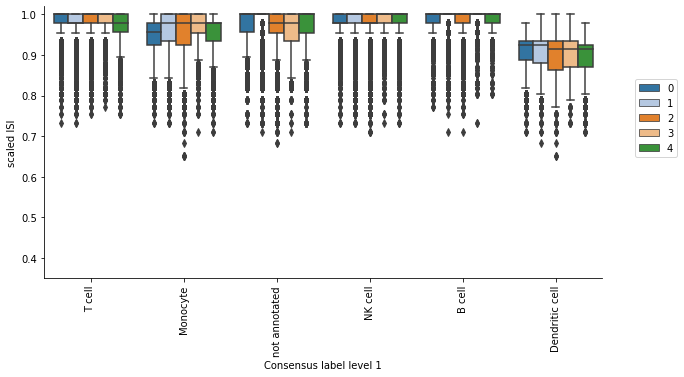

In [43]:
fig = plt.figure(figsize=(10,5))
p7 = sns.boxplot(data =dfi, x='consensus label', y='scaled ISI', hue='sample', palette='tab20')
p7.legend(bbox_to_anchor=(1.05,0.75))
p7.set_xlabel('Consensus label level 1')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([0.35,1.02])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_ISI_level1.pdf', bbox_inches='tight')
plt.show()

In [44]:
anno_keys = [key for key in adata_con.obs_keys() if key.count('cell type lvl 1')>0]

In [46]:
anno_cells = adata_con.obs[anno_keys]

In [48]:
ct_comp_lvl1 = dict()
for key in anno_keys:
    ct_comp_lvl1[key] =pd.crosstab(anno_cells[key][anno_cells[key]!='not annotated'], 
                                   'composition', normalize=True)*100

In [49]:
df_comp1 = pd.concat(ct_comp_lvl1).unstack()['composition']

Unscaled version.

In [50]:
div_ili0 = inverse_simpson_pandas(anno_cells, axis = 1, scale=False)

In [51]:
dfi0 = pd.DataFrame(data={'consensus label': div_ili0[0],
                          'ISI': div_ili0[1], 
                          'sample': adata_con.obs['sample'].cat.codes})

In [52]:
dfi0['consensus label'] = pd.Categorical(dfi0['consensus label'],
                                         categories= dfi0['consensus label'].value_counts().index.values)

In [53]:
dfi0.to_csv(f'../table/{today}_unscaledISI_level1.csv')

In [34]:
previous_day = '20230929'
if previous_day != today:
    dfi0 = pd.read_csv(f'../table/{previous_day}_unscaledISI_level1.csv', index_col=0)
else:
     dfi0 = pd.read_csv(f'../table/{today}_unscaledISI_level1.csv', index_col=0)

In [299]:
dfi0['consensus label'] = dfi0['consensus label'].cat.reorder_categories(['B cell','T cell', 'NK cell', 'Monocyte',  
                                                                          'Dendritic cell', 'not annotated'])

Generate a boxplot for the scaled Inverse Simpson index per cell type and sample.

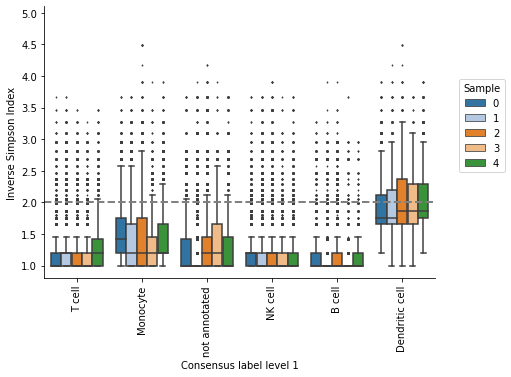

In [55]:
fig = plt.figure(figsize=(7,5))
p7 = sns.boxplot(data =dfi0, x='consensus label', y='ISI', hue='sample', palette='tab20', fliersize=1)
p7.legend(bbox_to_anchor=(1.05,0.75), title='Sample')
p7.set_xlabel('Consensus label level 1')
p7.set_ylabel('Inverse Simpson Index')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([0.8,5.1])
p7.set_xlim([-0.5,5.5])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
p7.hlines(y=2, xmin=-0.5, xmax=6, lw=2, color='grey', linestyle='--')
plt.savefig(f'./../figures/{today}_gating_test_unscaledISI_level1.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_unscaledISI_level1.png', bbox_inches='tight')
plt.show()

### cell type level 2

In [56]:
anno_keys2 = [key for key in adata_con.obs_keys() if key.count('cell type lvl 2')>0]

In [58]:
anno_cells2 = adata_con.obs[anno_keys2]

In [59]:
anno_cells2.head()

,cluster cell type lvl 2,manual cell type lvl 2_Gold,manual cell type lvl 2_p1,manual cell type lvl 2_p2,manual cell type lvl 2_p3,manual cell type lvl 2_p4,manual cell type lvl 2_p5,manual cell type lvl 2_p6,manual cell type lvl 2_p7.1,manual cell type lvl 2_p7.2,manual cell type lvl 2_p7.3
0-0,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated
1-0,CD8+ T cell,CD8+ T cell,T cell,T cell,CD8+ T cell,not annotated,CD8+ T cell,CD8+ T cell,CD8+ T cell,CD8+ T cell,CD8+ T cell
2-0,NK cell,NK cell,NK cell,NK cell,NK cell,not annotated,NK cell,NK cell,NK cell,NK cell,NK cell
3-0,not annotated,Classical monocyte,Classical monocyte,Classical monocyte,cDC,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte
4-0,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell


In [60]:
div_ili2 = inverse_simpson_pandas(anno_cells2, axis = 1)

In [61]:
dfi2 = pd.DataFrame(data={'consensus label': div_ili2[0], 
                          'scaled ISI': div_ili2[1], 
                          'sample': adata_con.obs['sample'].cat.codes})

In [62]:
dfi2['consensus label'] = pd.Categorical(dfi2['consensus label'], 
                                         categories= dfi2['consensus label'].value_counts().index.values)

In [63]:
dfi2.to_csv(f'../table/{today}_scaledISI_level2.csv')

In [45]:
previous_day = '20230929'
if previous_day != today:
    dfi2 = pd.read_csv(f'../table/{previous_day}_scaledISI_level2.csv', index_col=0)
else:
     dfi2 = pd.read_csv(f'../table/{today}_scaledISI_level2.csv', index_col=0)

Generate a boxplot for the scaled Inverse Simpson index per cell type and sample.

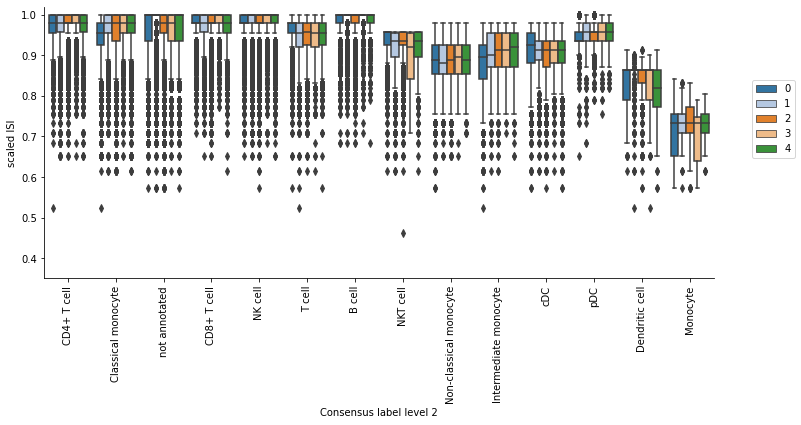

In [65]:
fig = plt.figure(figsize=(12,5))
p7 = sns.boxplot(data =dfi2, x='consensus label', y='scaled ISI', hue='sample',palette='tab20')
p7.legend(bbox_to_anchor=(1.05,0.75))
p7.set_xlabel('Consensus label level 2')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([0.35,1.02])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_ISI_level2.pdf', bbox_inches='tight')
plt.show()

Unscaled version.

In [66]:
div_ili02 = inverse_simpson_pandas(anno_cells2, axis = 1, scale=False)

In [67]:
dfi02 = pd.DataFrame(data={'consensus label': div_ili02[0], 
                           'ISI': div_ili02[1], 
                           'sample': adata_con.obs['sample'].cat.codes})

In [68]:
dfi02['consensus label'] = pd.Categorical(dfi02['consensus label'], 
                                          categories= dfi02['consensus label'].value_counts().index.values)

In [69]:
dfi02.to_csv(f'../table/{today}_unscaledISI_level2.csv')

In [52]:
previous_day = '20230929'
if previous_day != today:
    dfi02 = pd.read_csv(f'../table/{previous_day}_unscaledISI_level2.csv', index_col=0)
else:
     dfi02 = pd.read_csv(f'../table/{today}_unscaledISI_level2.csv', index_col=0)

In [71]:
dfi02['consensus label'] = dfi02['consensus label'].cat.reorder_categories([
    'B cell',
    'T cell',
    'CD4+ T cell', 
    'CD8+ T cell',
         'NKT cell','NK cell',
     'Monocyte',
        'Classical monocyte',  'Intermediate monocyte','Non-classical monocyte',
       'Dendritic cell','cDC', 'pDC',  
        'not annotated'])

Generate a boxplot for the scaled Inverse Simpson index per cell type and sample.

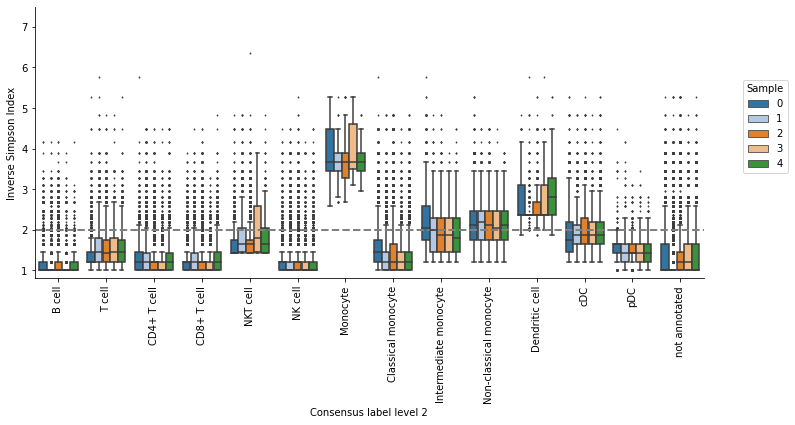

In [73]:
fig = plt.figure(figsize=(12,5))
p7 = sns.boxplot(data =dfi02, x='consensus label', y='ISI', hue='sample', palette='tab20', fliersize=1)
p7.legend(bbox_to_anchor=(1.05,0.75), title='Sample')
p7.set_xlabel('Consensus label level 2')
p7.set_ylabel('Inverse Simpson Index')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([0.8,7.5])
p7.set_xlim([-0.5,13.5])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
p7.hlines(y=2, xmin=-0.5, xmax=15, lw=2, color='grey', linestyle='--')
plt.savefig(f'./../figures/{today}_gating_test_unscaledISI_level2.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_unscaledISI_level2.png', bbox_inches='tight')
plt.show()

## Level 0: Valid cells

Selection of valid cells are denoted as:

In [74]:
debris_keys = [key for key in adata_con.obs_keys() if key.count('cell debris')>0]

In [75]:
joint_cells = adata_con.obs[debris_keys]

In [76]:
joint_cells.head()

,manual cell debris_Gold,manual cell debris_p1,manual cell debris_p2,manual cell debris_p3,manual cell debris_p4,manual cell debris_p5,manual cell debris_p6,manual cell debris_p7.1,manual cell debris_p7.2,manual cell debris_p7.3,cluster cell debris
0-0,debris,debris,debris,debris,debris,debris,debris,debris,debris,debris,debris
1-0,valid cell,valid cell,valid cell,valid cell,debris,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell
2-0,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell
3-0,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,debris
4-0,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell


In [77]:
joint_cells['sample']=adata_con.obs['sample'].cat.codes

/tmp/ipykernel_379030/1637615481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_cells['sample']=adata_con.obs['sample'].cat.codes


Compute Jaccard Index over all cells.

In [78]:
res = {}
for key in debris_keys:
    res[key] = sklearn.metrics.jaccard_score(y_true=joint_cells['manual cell debris_Gold'],
                                             y_pred=joint_cells[key],
                                             pos_label='valid cell'
                                            )
    

In [79]:
res.pop('manual cell debris_Gold')

1.0

In [80]:
res

{'manual cell debris_p1': 0.9637131869556361,
 'manual cell debris_p2': 0.9380568394897872,
 'manual cell debris_p3': 0.9654241570977894,
 'manual cell debris_p4': 0.7868021011965362,
 'manual cell debris_p5': 0.9585829725540244,
 'manual cell debris_p6': 0.7186726178445854,
 'manual cell debris_p7.1': 0.9780628648557969,
 'manual cell debris_p7.2': 0.9779047997211263,
 'manual cell debris_p7.3': 0.9780186885394759,
 'cluster cell debris': 0.87508627595982}

In [81]:
df = pd.Series(res)
df0 = pd.DataFrame(data={'Person': df.index, 'Jaccard': df.values})

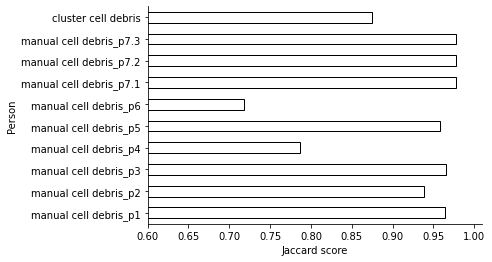

In [82]:
p0 = df0.plot.barh(x='Person', y='Jaccard', color='white', edgecolor='black')
p0.legend().remove()
p0.set_xlabel('Jaccard score')
p0.spines['top'].set_visible(False)
p0.spines['right'].set_visible(False)
p0.set_xlim([0.6,1.01])
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells.png', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells.pdf', bbox_inches='tight')
plt.show()

To compute a hierarchical clustering, we have to compute the pairwise Jaccard score for all combinations.

In [83]:
res = {}
for key in debris_keys:
    res_tmp = []
    print(f'Ref: {key}')
    #if key == 'manual cell debris_Gold':
    #    continue
    for key1 in debris_keys:
        print(key1)
    #    if key == 'manual cell debris_Gold':
    #        continue
        tmp = sklearn.metrics.jaccard_score(y_true=joint_cells[key],
                                             y_pred=joint_cells[key1],
                                             pos_label='valid cell'
                                            )
        res_tmp.append(tmp)
    res[key] = res_tmp

Ref: manual cell debris_Gold
manual cell debris_Gold
manual cell debris_p1
manual cell debris_p2
manual cell debris_p3
manual cell debris_p4
manual cell debris_p5
manual cell debris_p6
manual cell debris_p7.1
manual cell debris_p7.2
manual cell debris_p7.3
cluster cell debris
Ref: manual cell debris_p1
manual cell debris_Gold
manual cell debris_p1
manual cell debris_p2
manual cell debris_p3
manual cell debris_p4
manual cell debris_p5
manual cell debris_p6
manual cell debris_p7.1
manual cell debris_p7.2
manual cell debris_p7.3
cluster cell debris
Ref: manual cell debris_p2
manual cell debris_Gold
manual cell debris_p1
manual cell debris_p2
manual cell debris_p3
manual cell debris_p4
manual cell debris_p5
manual cell debris_p6
manual cell debris_p7.1
manual cell debris_p7.2
manual cell debris_p7.3
cluster cell debris
Ref: manual cell debris_p3
manual cell debris_Gold
manual cell debris_p1
manual cell debris_p2
manual cell debris_p3
manual cell debris_p4
manual cell debris_p5
manual cell 

In [84]:
df = pd.DataFrame(res, index=res.keys())

In [85]:
df

,manual cell debris_Gold,manual cell debris_p1,manual cell debris_p2,manual cell debris_p3,manual cell debris_p4,manual cell debris_p5,manual cell debris_p6,manual cell debris_p7.1,manual cell debris_p7.2,manual cell debris_p7.3,cluster cell debris
manual cell debris_Gold,1.000000,0.963713,0.938057,0.965424,0.786802,0.958583,0.718673,0.978063,0.977905,0.978019,0.875086
manual cell debris_p1,0.963713,1.000000,0.919381,0.968144,0.810729,0.974168,0.724867,0.974801,0.974641,0.974746,0.859375
manual cell debris_p2,0.938057,0.919381,1.000000,0.926431,0.824169,0.920495,0.700687,0.928526,0.928437,0.928490,0.861373
manual cell debris_p3,0.965424,0.968144,0.926431,1.000000,0.805825,0.960613,0.721417,0.972394,0.972235,0.972350,0.860232
manual cell debris_p4,0.786802,0.810729,0.824169,0.805825,1.000000,0.803442,0.627692,0.794316,0.794411,0.794319,0.771239
manual cell debris_p5,0.958583,0.974168,0.920495,0.960613,0.803442,1.000000,0.727062,0.974743,0.974590,0.974689,0.864499
manual cell debris_p6,0.718673,0.724867,0.700687,0.721417,0.627692,0.727062,1.000000,0.730272,0.730139,0.730232,0.659288
manual cell debris_p7.1,0.978063,0.974801,0.928526,0.972394,0.794316,0.974743,0.730272,1.000000,0.999834,0.999928,0.874205
manual cell debris_p7.2,0.977905,0.974641,0.928437,0.972235,0.794411,0.974590,0.730139,0.999834,1.000000,0.999880,0.874142
manual cell debris_p7.3,0.978019,0.974746,0.928490,0.972350,0.794319,0.974689,0.730232,0.999928,0.999880,1.000000,0.874178


In [86]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [87]:
Z = linkage(df, "ward")

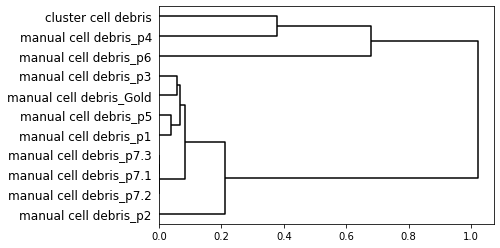

In [88]:
p2 = dendrogram(Z, labels = df.index, leaf_rotation=0, color_threshold=0, above_threshold_color='k', orientation='right')
plt.savefig(f'./../figures/{today}_gating_test_hierclust_valid_cells.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_hierclust_valid_cells.png', bbox_inches='tight')
plt.show()

Remove "Gold" standard to match hierarchical clustering with Jaccard index plot.

In [89]:
df_noGold = df.drop('manual cell debris_Gold', inplace=False)

In [90]:
df_noGold.drop('manual cell debris_Gold', inplace=True, axis=1)

In [91]:
df_tmp = df['manual cell debris_Gold']

In [92]:
df_tmp.drop('manual cell debris_Gold', inplace=True)

In [93]:
person_order = p2['ivl'][::-1]

In [94]:
person_order.remove('manual cell debris_Gold')

In [95]:
df0 = pd.DataFrame(data={'Rater': df_tmp.index, 'Jaccard': df_tmp.values})
df0['Rater'] = pd.Categorical(df0['Rater'], categories=person_order)
df0.sort_values('Rater', inplace=True, ascending=False)

In [96]:
Z2 = linkage(df_noGold, "ward")

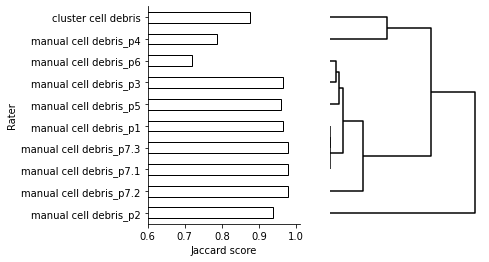

In [97]:
fig, axs = plt.subplots(1,2, sharey=False)
axs[0] = df0.plot.barh(x='Rater', y='Jaccard', color='white', edgecolor='black', ax=axs[0])
axs[0].legend().remove()
axs[0].set_xlabel('Jaccard score')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlim([0.6,1.01])
p4 = dendrogram(Z2, labels = np.repeat('', df_noGold.shape[0]), 
                    leaf_rotation=0, color_threshold=0, above_threshold_color='k', orientation='right', ax=axs[1])
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].get_xaxis().set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_hierclust.png', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_hierclust.pdf', bbox_inches='tight')
plt.show()

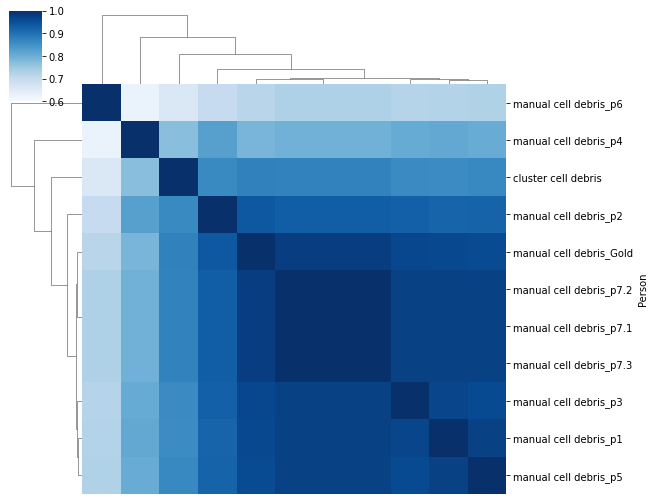

In [98]:
p3 = sns.clustermap(df, cmap='Blues', vmin=0.6, dendrogram_ratio=0.15, xticklabels=False, figsize=(9,7))
ax = p3.ax_heatmap
ax.set_ylabel('Person')
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_clustermap.png', bbox_inches='tight')
plt.show()

Next, we compute the Jaccard Index per sample and add it to the bar plot of the overall overlap.

In [99]:
sample_keys = adata_con.obs['sample'].cat.codes.unique()

In [100]:
res_sample = dict()
for key in debris_keys:
    print(f"Ref: {key}")
    tmp_list = []
    for sample_key in sample_keys:
        print(f"Sample: {sample_key}")
        if key == 'manual cell debris_Gold':
            tmp = 1
        else:
            sample_tmp = joint_cells[['manual cell debris_Gold', key]][joint_cells['sample']==sample_key]
            tmp = sklearn.metrics.jaccard_score(y_true=sample_tmp['manual cell debris_Gold'],
                                             y_pred=sample_tmp[key],
                                             pos_label='valid cell'
                                            )
        tmp_list.append(tmp)
    res_sample[key] = tmp_list



Ref: manual cell debris_Gold
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p1
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p2
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p3
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p4
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p5
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p6
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p7.1
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p7.2
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: manual cell debris_p7.3
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4
Ref: cluster cell debris
Sample: 0
Sample: 1
Sample: 2
Sample: 3
Sample: 4


In [114]:
df_sample = pd.DataFrame(res_sample, index=sample_keys)

In [115]:
df_sample.drop('manual cell debris_Gold', axis=1, inplace=True)

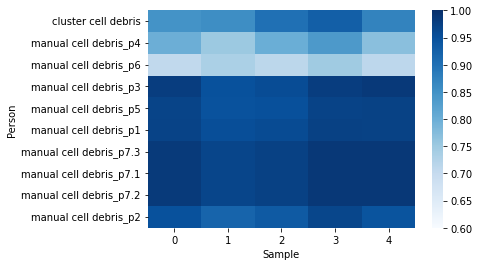

In [103]:
ax = sns.heatmap(data=df_sample.loc[:, person_order].T, cmap='Blues', vmin=0.6, vmax=1)
ax.set_xlabel("Sample")
ax.set_ylabel("Person")
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_heatmap.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_heatmap.png', bbox_inches='tight')
plt.show()

In [119]:
df_sample = df_sample.unstack().reset_index()
df_sample.rename({0 : 'Jaccard score', 'level_0': 'Rater', 'level_1': 'Sample'}, axis=1, inplace=True)

In [124]:
df_sample['Rater'] = pd.Categorical(df_sample['Rater'], categories=person_order)
df_sample.sort_values('Rater', inplace=True, ascending=False)

<AxesSubplot:xlabel='Jaccard', ylabel='Rater'>

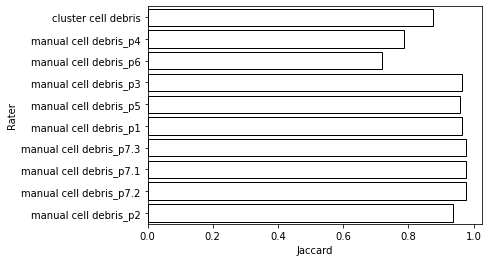

In [107]:
sns.barplot(y=df0['Rater'], x=df0['Jaccard'], edgecolor='k', color='white')

<AxesSubplot:xlabel='Jaccard score', ylabel='Rater'>

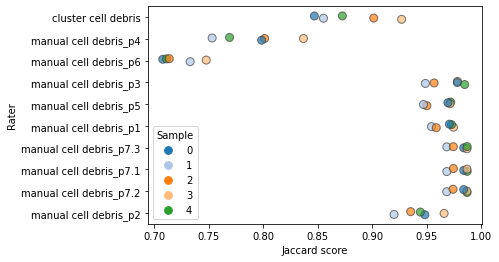

In [127]:
sns.stripplot( data =df_sample, y='Rater', x='Jaccard score', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)

In [352]:
#df_sample.reset_index(inplace=True)

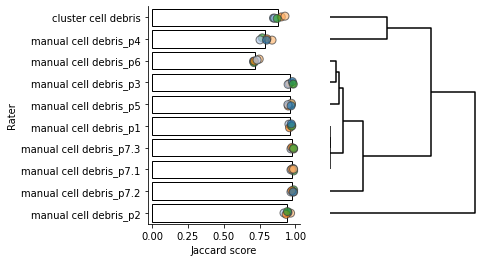

In [130]:
fig, axs = plt.subplots(1,2, sharey=False)
p0 = sns.barplot(y=df0['Rater'], x=df0['Jaccard'], edgecolor='k', color='white', ax=axs[0])
axs[0].set_xlabel('Jaccard score')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlim([-0.03,1.03])
p3 = sns.stripplot(ax=axs[0], data =df_sample, y='Rater', x='Jaccard score', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs[0].legend().remove()
p4 = dendrogram(Z2, labels = np.repeat('', df_noGold.shape[0]), 
                    leaf_rotation=0, color_threshold=0, above_threshold_color='k', orientation='right', ax=axs[1])
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].get_xaxis().set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_hierclust.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_hierclust.png', bbox_inches='tight')
plt.show()

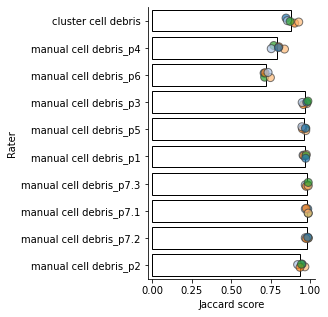

In [135]:
rcParams['figure.figsize']=(3,5)
fig, axs = plt.subplots(1,1, sharey=False)

p0 = sns.barplot(y=df0['Rater'], x=df0['Jaccard'], edgecolor='k', color='white', ax=axs)
axs.set_xlabel('Jaccard score')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xlim([-0.03,1.03])
p3 = sns.stripplot(ax=axs, data =df_sample, y='Rater', x='Jaccard score', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.legend().remove()
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_nodend.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_nodend.png', bbox_inches='tight')
plt.show()

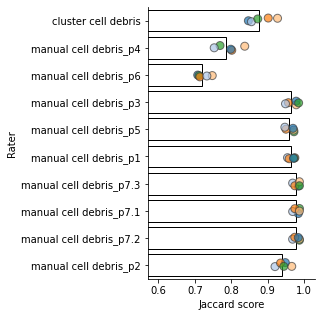

In [137]:
rcParams['figure.figsize']=(3,5)
fig, axs = plt.subplots(1,1, sharey=False)

p0 = sns.barplot(y=df0['Rater'], x=df0['Jaccard'], edgecolor='k', color='white', ax=axs)
axs.set_xlabel('Jaccard score')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xlim([0.57,1.03])
p3 = sns.stripplot(ax=axs, data =df_sample, y='Rater', x='Jaccard score', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.legend().remove()
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_nodend2.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_nodend2.png', bbox_inches='tight')
plt.show()

### Overlap visualization

Next, we visualize the number of cells recognized as valid in an upset plot.

In [140]:
jc_bool = joint_cells[debris_keys]=='valid cell'

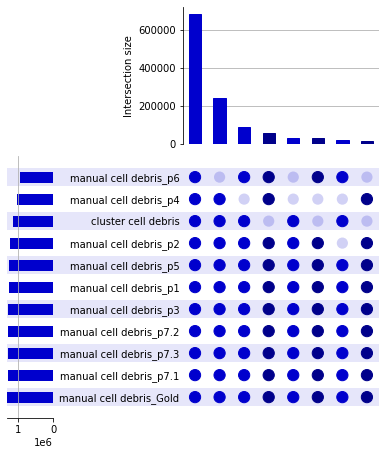

In [141]:
df_up = jc_bool.groupby(list(jc_bool.columns.values)).size()
upset = UpSet(df_up, orientation='horizontal', sort_by='cardinality', 
     min_subset_size=10000, subset_size='sum', 
     #show_percentages=True,
     min_degree=9,
     with_lines=False, facecolor="mediumblue",shading_color="lavender"
    )

upset.style_subsets(absent=["cluster cell debris"],
                    facecolor="darkblue")

upset.plot()
plt.savefig(f'./../figures/{today}_overlap_valid_cells_upset.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_overlap_valid_cells_upset.png', bbox_inches='tight')
plt.show()

Note: This plot is in the corresponding supplementary figure.

Note: Simplify the categories of this plot to 'valid in all', 'valid in all but one', 'valid in all but 2'. And intersect with Gold standard and non-gating based cell selection.

In [142]:
valid_sum = np.sum(jc_bool, axis=1)

In [143]:
df = pd.crosstab(valid_sum, "sum valid")/jc_bool.shape[0]*100
df = df[::-1]

In [145]:
jc_bool['manual cell debris_Gold'].mean()

0.8940922369750924

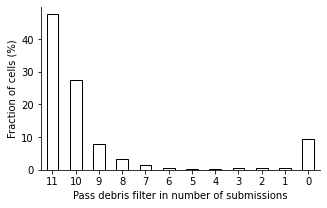

In [148]:
rcParams['figure.figsize']=(5,3)
p5 = df.plot.bar(color='white', edgecolor='black',rot=0)
p5.legend().remove()
p5.set_xlabel('Pass debris filter in number of submissions')
p5.set_ylabel('Fraction of cells (%)')
p5.spines['top'].set_visible(False)
p5.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_overlap_valid_cells_hist.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_overlap_valid_cells_hist.png', bbox_inches='tight')
plt.show()

Group by sample and plot as stacked barplot.

In [149]:
valid_sum = np.sum(jc_bool, axis=1)
jc_bool2 = pd.DataFrame({'sum_valid': valid_sum, 'sample': adata_con.obs['sample'].cat.codes})

In [150]:
df_valid = pd.crosstab(jc_bool2['sample'], jc_bool2['sum_valid'], normalize=1)*100

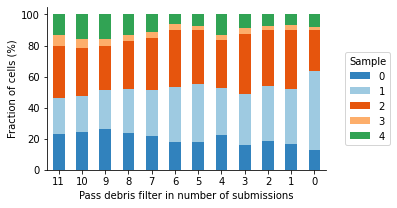

In [152]:
p6 = df_valid.T[::-1].plot(kind='bar', stacked=True, rot=0, color=coloring)
p6.legend(bbox_to_anchor=(1.05, 0.75), title='Sample')
p6.set_xlabel('Pass debris filter in number of submissions')
p6.set_ylabel('Fraction of cells (%)')
p6.spines['top'].set_visible(False)
p6.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_overlap_valid_cells_bar.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_overlap_valid_cells_bar.png', bbox_inches='tight')
plt.show()

In [153]:
df_valid2 = pd.crosstab(jc_bool2['sample'], jc_bool2['sum_valid'])*100

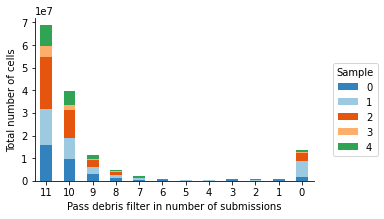

In [154]:
p6 = df_valid2.T[::-1].plot(kind='bar', stacked=True, rot=0, color=coloring)
p6.legend(bbox_to_anchor=(1.05, 0.75), title='Sample')
p6.set_xlabel('Pass debris filter in number of submissions')
p6.set_ylabel('Total number of cells')
p6.spines['top'].set_visible(False)
p6.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_overlap_valid_cells_bar2.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_overlap_valid_cells_bar2.png', bbox_inches='tight')
plt.show()

## Level 1: Coarse cell type annotation

In this evaluation, we inspect the accordance of cell type annotations using the normalized mutual information criterion. We create four different versions of it, because all submissions differ in the number of valid cells to begin with and subsetting to the valid cells in the Gold standard may introduce bias. 
* Version 1: Use all cells
* Version 2: Use valid cells of the Gold standard
* Version 3: Use valid cells of the subset of Gold standard and tested group
* Version 4: Use valid cells based on the consensus (valid in 9 or more submissions)
* Version 5: Compare to consensus obtained from all submissions

In [164]:
anno_keys = [key for key in adata_con.obs_keys() if key.count('cell type lvl 1')>0]

In [166]:
anno_cells = adata_con.obs[anno_keys]

In [168]:
anno_cells['sample']=adata_con.obs['sample'].cat.codes

/tmp/ipykernel_379030/3006737827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_cells['sample']=adata_con.obs['sample'].cat.codes


### Version 1:

In [169]:
nmi = {}
for key in anno_keys:
    print(key)
    nmi[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cells['manual cell type lvl 1_Gold'],
                                             labels_pred=anno_cells[key]
                                            )
    

cluster cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3


In [170]:
df_nmi = pd.Series(nmi)
df_nmi0 = pd.DataFrame(data={'Person': df_nmi.index, 'NMI': df_nmi.values})
df_nmi0 = df_nmi0[df_nmi0['Person']!='manual cell type lvl 1_Gold']

Next, we compute the NMI per sample.

In [171]:
sample_keys = anno_cells['sample'].unique()

In [172]:
res_sample_nmi = dict()
for key in anno_keys:
    if key == 'manual cell type lvl 1_Gold':
        continue
    tmp_list = []
    for sample_key in sample_keys:

        sample_tmp = anno_cells[['manual cell type lvl 1_Gold', key]][anno_cells['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['manual cell type lvl 1_Gold'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi[key] = tmp_list

df_sample_nmi = pd.DataFrame(res_sample_nmi, index=sample_keys)

In [173]:
df_sample_nmi = df_sample_nmi.unstack().reset_index()
df_sample_nmi.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi['Person'] = pd.Categorical(df_sample_nmi['Person'], categories=df_nmi0['Person'])
df_sample_nmi.sort_values('Person', inplace=True, ascending=False)

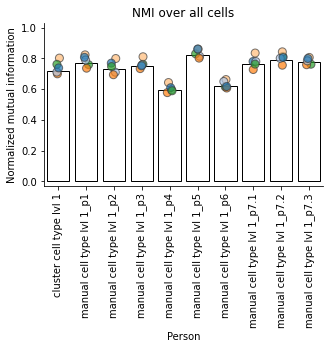

In [174]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi0['Person'], y=df_nmi0['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over all cells')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()

plt.savefig(f'./../figures/{today}_gating_test_nmi_v1_level1.png', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v1_level1.pdf', bbox_inches='tight')
plt.show()

### Version 2:

In [175]:
anno_cells2 = anno_cells.loc[np.invert(anno_cells['manual cell type lvl 1_Gold']=='not annotated')].copy()

In [176]:
nmi2 = {}
for key in anno_keys:
    print(key)
    nmi2[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cells2['manual cell type lvl 1_Gold'],
                                             labels_pred=anno_cells2[key]
                                            )
    

cluster cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3


In [178]:
df_nmi2 = pd.Series(nmi2)
df_nmi02 = pd.DataFrame(data={'Person': df_nmi2.index, 'NMI': df_nmi2.values})
df_nmi02 = df_nmi02[df_nmi02['Person']!='manual cell type lvl 1_Gold']

Next, we compute the NMI per sample.

In [179]:
sample_keys = anno_cells2['sample'].unique()

In [180]:
res_sample_nmi2 = dict()
for key in anno_keys:
    if key == 'manual cell type lvl 1_Gold':
        continue
    tmp_list = []
    for sample_key in sample_keys:

        sample_tmp = anno_cells2[['manual cell type lvl 1_Gold', key]][anno_cells2['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['manual cell type lvl 1_Gold'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi2[key] = tmp_list

df_sample_nmi2 = pd.DataFrame(res_sample_nmi2, index=sample_keys)

In [181]:
df_sample_nmi2 = df_sample_nmi2.unstack().reset_index()
df_sample_nmi2.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi2['Person'] = pd.Categorical(df_sample_nmi2['Person'], categories=df_nmi02['Person'])
df_sample_nmi2.sort_values('Person', inplace=True, ascending=False)

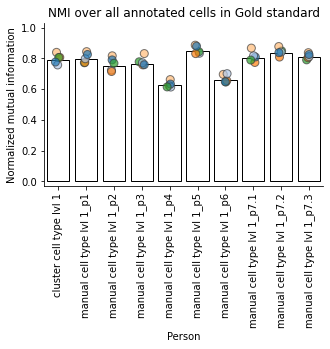

In [182]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi02['Person'], y=df_nmi02['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi2, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over all annotated cells in Gold standard')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()

plt.savefig(f'./../figures/{today}_gating_test_nmi_v2_level1.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v2_level1.png', bbox_inches='tight')
plt.show()

### Version 3:

In [183]:
nmi3 = {}
for key in anno_keys:
    print(key)
    if key.endswith('Gold'):
        continue
    anno_tmp = anno_cells[['manual cell type lvl 1_Gold', key]].copy()
    anno_tmp = anno_tmp.loc[np.sum(anno_tmp == 'not annotated',axis=1)==0]
    nmi3[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_tmp['manual cell type lvl 1_Gold'],
                                             labels_pred=anno_tmp[key]
                                            )

cluster cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3


In [185]:
df_nmi3 = pd.Series(nmi3)
df_nmi03 = pd.DataFrame(data={'Person': df_nmi3.index, 'NMI': df_nmi3.values})
df_nmi03 = df_nmi03[df_nmi03['Person']!='manual cell type lvl 1_Gold']

Next, we compute the NMI per sample.

In [186]:
sample_keys = anno_cells['sample'].unique()

In [187]:
res_sample_nmi3 = dict()
for key in anno_keys:
    if key == 'manual cell type lvl 1_Gold':
        continue
    tmp_list = []
    anno_tmp = anno_cells[['sample','manual cell type lvl 1_Gold', key]].copy()
    anno_tmp = anno_tmp.loc[np.sum(anno_tmp == 'not annotated',axis=1)==0]
    for sample_key in sample_keys:

        sample_tmp = anno_tmp[anno_tmp['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['manual cell type lvl 1_Gold'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi3[key] = tmp_list

df_sample_nmi3 = pd.DataFrame(res_sample_nmi3, index=sample_keys)

In [188]:
df_sample_nmi3 = df_sample_nmi3.unstack().reset_index()
df_sample_nmi3.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi3['Person'] = pd.Categorical(df_sample_nmi3['Person'], categories=df_nmi03['Person'])
df_sample_nmi3.sort_values('Person', inplace=True, ascending=False)

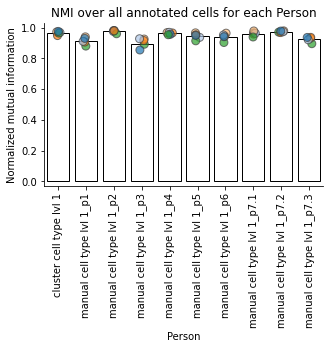

In [189]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi03['Person'], y=df_nmi03['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi3, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over all annotated cells for each Person')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()

plt.savefig(f'./../figures/{today}_gating_test_nmi_v3_level1.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v3_level1.png', bbox_inches='tight')
plt.show()

### Version 4:

In [190]:
anno_cons = anno_cells[np.sum(anno_cells =='not annotated', axis=1)<=3].copy()

In [191]:
nmi4 = {}
for key in anno_keys:
    print(key)
    if key.endswith('Gold'):
        continue
    nmi4[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cons['manual cell type lvl 1_Gold'],
                                             labels_pred=anno_cons[key]
                                            )

cluster cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3


In [194]:
df_nmi4 = pd.Series(nmi4)
df_nmi04 = pd.DataFrame(data={'Person': df_nmi4.index, 'NMI': df_nmi4.values})
df_nmi04 = df_nmi04[df_nmi04['Person']!='manual cell type lvl 1_Gold']

Next, we compute the NMI per sample.

In [195]:
sample_keys = anno_cons['sample'].unique()

In [196]:
res_sample_nmi4 = dict()
for key in anno_keys:
    if key == 'manual cell type lvl 1_Gold':
        continue
    tmp_list = []
    anno_tmp = anno_cons[['sample','manual cell type lvl 1_Gold', key]].copy()
    for sample_key in sample_keys:

        sample_tmp = anno_tmp[anno_tmp['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['manual cell type lvl 1_Gold'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi4[key] = tmp_list

df_sample_nmi4 = pd.DataFrame(res_sample_nmi4, index=sample_keys)

In [197]:
df_sample_nmi4 = df_sample_nmi4.unstack().reset_index()
df_sample_nmi4.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi4['Person'] = pd.Categorical(df_sample_nmi4['Person'], categories=df_nmi04['Person'])
df_sample_nmi4.sort_values('Person', inplace=True, ascending=False)

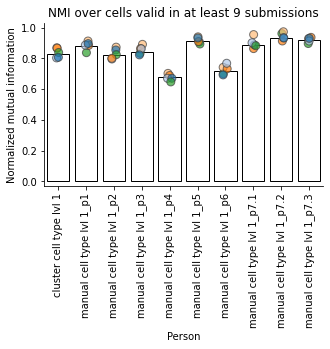

In [198]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi04['Person'], y=df_nmi04['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi4, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over cells valid in at least 9 submissions')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()

plt.savefig(f'./../figures/{today}_gating_test_nmi_v4_level1.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v4_level1.png', bbox_inches='tight')
plt.show()

### Version 5:

In [199]:
nmi5 = {}
for key in anno_keys:
    print(key)
    nmi5[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=dfi['consensus label'],
                                             labels_pred=anno_cells[key]
                                            )

cluster cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3


In [201]:
df_nmi5 = pd.Series(nmi5)
df_nmi05 = pd.DataFrame(data={'Person': df_nmi5.index, 'NMI': df_nmi5.values})
#df_nmi05 = df_nmi05[df_nmi05['Person']!='manual cell type lvl 1_Gold']

Next, we compute the NMI per sample.

In [202]:
sample_keys = anno_cells['sample'].unique()

In [203]:
anno_cells['consensus label'] = dfi0['consensus label']

/tmp/ipykernel_379030/1238070599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_cells['consensus label'] = dfi0['consensus label']


In [204]:
res_sample_nmi5 = dict()
for key in anno_keys:
    tmp_list = []
    anno_tmp = anno_cells[['sample','consensus label', key]].copy()
    for sample_key in sample_keys:

        sample_tmp = anno_tmp[anno_tmp['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['consensus label'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi5[key] = tmp_list

df_sample_nmi5 = pd.DataFrame(res_sample_nmi5, index=sample_keys)

In [205]:
df_sample_nmi5 = df_sample_nmi5.unstack().reset_index()
df_sample_nmi5.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi5['Person'] = pd.Categorical(df_sample_nmi5['Person'], categories=df_nmi05['Person'])
df_sample_nmi5.sort_values('Person', inplace=True, ascending=False)

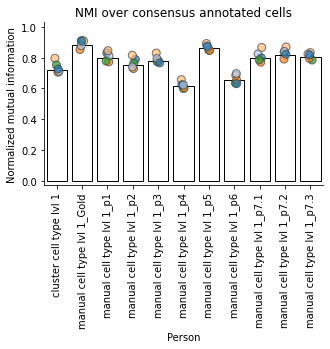

In [206]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi05['Person'], y=df_nmi05['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi5, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over consensus annotated cells')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()

plt.savefig(f'./../figures/{today}_gating_test_nmi_v5_level1.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v5_level1.png', bbox_inches='tight')
plt.show()

## Level 2: Finer cell type annotation

In this evaluation, we inspect the accordance of cell type annotations using the normalized mutual information criterion. We create four different versions of it, because all submissions differ in the number of valid cells to begin with and subsetting to the valid cells in the Gold standard may introduce bias. 
* Version 1: Use all cells
* Version 2: Use valid cells of the Gold standard
* Version 3: Use valid cells of the subset of Gold standard and tested group
* Version 4: Use valid cells based on the consensus (valid in 9 or more submissions)
* Version 5: Compare to consensus obtained from all submissions

In [207]:
anno_keys2 = [key for key in adata_con.obs_keys() if key.count('cell type lvl 2')>0]

In [209]:
anno_cells2 = adata_con.obs[anno_keys2]

In [211]:
anno_cells2['sample']=adata_con.obs['sample'].cat.codes

/tmp/ipykernel_379030/3481677642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_cells2['sample']=adata_con.obs['sample'].cat.codes


### Version 1:

In [212]:
nmi = {}
for key in anno_keys2:
    print(key)
    nmi[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cells2['manual cell type lvl 2_Gold'],
                                             labels_pred=anno_cells2[key]
                                            )
    

cluster cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3


In [213]:
df_nmi = pd.Series(nmi)
df_nmi0 = pd.DataFrame(data={'Person': df_nmi.index, 'NMI': df_nmi.values})
df_nmi0 = df_nmi0[df_nmi0['Person']!='manual cell type lvl 2_Gold']

Next, we compute the NMI per sample.

In [214]:
sample_keys = anno_cells2['sample'].unique()

In [215]:
res_sample_nmi = dict()
for key in anno_keys2:
    if key == 'manual cell type lvl 2_Gold':
        continue
    tmp_list = []
    for sample_key in sample_keys:

        sample_tmp = anno_cells2[['manual cell type lvl 2_Gold', key]][anno_cells2['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['manual cell type lvl 2_Gold'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi[key] = tmp_list

df_sample_nmi = pd.DataFrame(res_sample_nmi, index=sample_keys)

In [216]:
df_sample_nmi = df_sample_nmi.unstack().reset_index()
df_sample_nmi.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi['Person'] = pd.Categorical(df_sample_nmi['Person'], categories=df_nmi0['Person'])
df_sample_nmi.sort_values('Person', inplace=True, ascending=False)

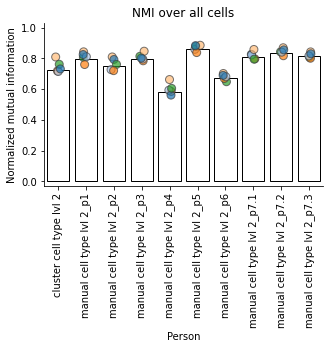

In [217]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi0['Person'], y=df_nmi0['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over all cells')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()
plt.savefig(f'./../figures/{today}_gating_test_nmi_v1_level2.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v1_level2.png', bbox_inches='tight')
plt.show()

### Version 2:

In [218]:
anno_cells22 = anno_cells2.loc[np.invert(anno_cells2['manual cell type lvl 2_Gold']=='not annotated')].copy()

In [219]:
nmi2 = {}
for key in anno_keys2:
    print(key)
    nmi2[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cells22['manual cell type lvl 2_Gold'],
                                             labels_pred=anno_cells22[key]
                                            )
    

cluster cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3


In [221]:
df_nmi2 = pd.Series(nmi2)
df_nmi02 = pd.DataFrame(data={'Person': df_nmi2.index, 'NMI': df_nmi2.values})
df_nmi02 = df_nmi02[df_nmi02['Person']!='manual cell type lvl 2_Gold']

Next, we compute the NMI per sample.

In [222]:
sample_keys = anno_cells2['sample'].unique()

In [223]:
res_sample_nmi2 = dict()
for key in anno_keys2:
    if key == 'manual cell type lvl 2_Gold':
        continue
    tmp_list = []
    for sample_key in sample_keys:

        sample_tmp = anno_cells22[['manual cell type lvl 2_Gold', key]][anno_cells22['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['manual cell type lvl 2_Gold'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi2[key] = tmp_list

df_sample_nmi2 = pd.DataFrame(res_sample_nmi2, index=sample_keys)

In [224]:
df_sample_nmi2 = df_sample_nmi2.unstack().reset_index()
df_sample_nmi2.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi2['Person'] = pd.Categorical(df_sample_nmi2['Person'], categories=df_nmi02['Person'])
df_sample_nmi2.sort_values('Person', inplace=True, ascending=False)

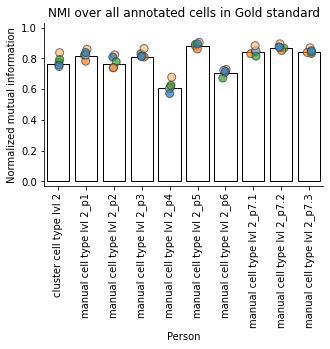

In [225]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi02['Person'], y=df_nmi02['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi2, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over all annotated cells in Gold standard')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()
plt.savefig(f'./../figures/{today}_gating_test_nmi_v2_level2.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v2_level2.png', bbox_inches='tight')
plt.show()

### Version 3:

In [226]:
nmi3 = {}
for key in anno_keys2:
    print(key)
    if key.endswith('Gold'):
        continue
    anno_tmp = anno_cells2[['manual cell type lvl 2_Gold', key]].copy()
    anno_tmp = anno_tmp.loc[np.sum(anno_tmp == 'not annotated',axis=1)==0]
    nmi3[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_tmp['manual cell type lvl 2_Gold'],
                                             labels_pred=anno_tmp[key]
                                            )

cluster cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3


In [228]:
df_nmi3 = pd.Series(nmi3)
df_nmi03 = pd.DataFrame(data={'Person': df_nmi3.index, 'NMI': df_nmi3.values})
df_nmi03 = df_nmi03[df_nmi03['Person']!='manual cell type lvl 2_Gold']

Next, we compute the NMI per sample.

In [229]:
sample_keys = anno_cells2['sample'].unique()

In [230]:
res_sample_nmi3 = dict()
for key in anno_keys2:
    if key == 'manual cell type lvl 2_Gold':
        continue
    tmp_list = []
    anno_tmp = anno_cells2[['sample','manual cell type lvl 2_Gold', key]].copy()
    anno_tmp = anno_tmp.loc[np.sum(anno_tmp == 'not annotated',axis=1)==0]
    for sample_key in sample_keys:

        sample_tmp = anno_tmp[anno_tmp['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['manual cell type lvl 2_Gold'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi3[key] = tmp_list

df_sample_nmi3 = pd.DataFrame(res_sample_nmi3, index=sample_keys)

In [231]:
df_sample_nmi3 = df_sample_nmi3.unstack().reset_index()
df_sample_nmi3.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi3['Person'] = pd.Categorical(df_sample_nmi3['Person'], categories=df_nmi03['Person'])
df_sample_nmi3.sort_values('Person', inplace=True, ascending=False)

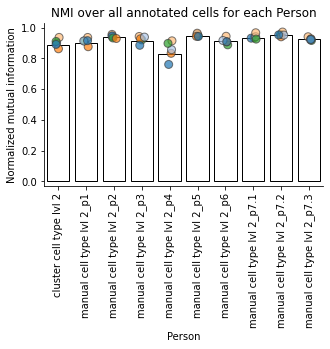

In [232]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi03['Person'], y=df_nmi03['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi3, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over all annotated cells for each Person')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()

plt.savefig(f'./../figures/{today}_gating_test_nmi_v3_level2.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v3_level2.png', bbox_inches='tight')
plt.show()

### Version 4:

In [233]:
anno_cons = anno_cells2[np.sum(anno_cells2 =='not annotated', axis=1)<=3].copy()

In [234]:
nmi4 = {}
for key in anno_keys2:
    print(key)
    if key.endswith('Gold'):
        continue
    nmi4[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cons['manual cell type lvl 2_Gold'],
                                             labels_pred=anno_cons[key]
                                            )

cluster cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3


In [237]:
df_nmi4 = pd.Series(nmi4)
df_nmi04 = pd.DataFrame(data={'Person': df_nmi4.index, 'NMI': df_nmi4.values})
df_nmi04 = df_nmi04[df_nmi04['Person']!='manual cell type lvl 2_Gold']

Next, we compute the NMI per sample.

In [238]:
sample_keys = anno_cons['sample'].unique()

In [239]:
res_sample_nmi4 = dict()
for key in anno_keys2:
    if key == 'manual cell type lvl 2_Gold':
        continue
    tmp_list = []
    anno_tmp = anno_cons[['sample','manual cell type lvl 2_Gold', key]].copy()
    for sample_key in sample_keys:

        sample_tmp = anno_tmp[anno_tmp['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['manual cell type lvl 2_Gold'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi4[key] = tmp_list

df_sample_nmi4 = pd.DataFrame(res_sample_nmi4, index=sample_keys)

In [240]:
df_sample_nmi4 = df_sample_nmi4.unstack().reset_index()
df_sample_nmi4.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi4['Person'] = pd.Categorical(df_sample_nmi4['Person'], categories=df_nmi04['Person'])
df_sample_nmi4.sort_values('Person', inplace=True, ascending=False)

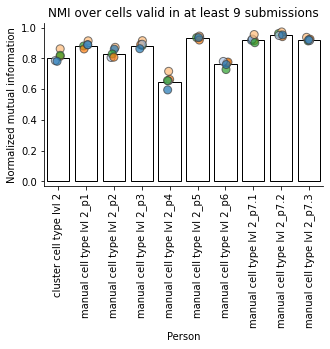

In [241]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi04['Person'], y=df_nmi04['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi4, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over cells valid in at least 9 submissions')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()

plt.savefig(f'./../figures/{today}_gating_test_nmi_v4_level2.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v4_level2.png', bbox_inches='tight')
plt.show()

### Version 5:

In [242]:
nmi5 = {}
for key in anno_keys2:
    print(key)
    nmi5[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=dfi02['consensus label'],
                                             labels_pred=anno_cells2[key]
                                            )

cluster cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3


In [244]:
df_nmi5 = pd.Series(nmi5)
df_nmi05 = pd.DataFrame(data={'Person': df_nmi5.index, 'NMI': df_nmi5.values})

Next, we compute the NMI per sample.

In [245]:
sample_keys = anno_cells2['sample'].unique()

In [246]:
anno_cells2['consensus label'] = dfi02['consensus label']

/tmp/ipykernel_379030/1366442558.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_cells2['consensus label'] = dfi02['consensus label']


In [247]:
res_sample_nmi5 = dict()
for key in anno_keys2:
    tmp_list = []
    anno_tmp = anno_cells2[['sample','consensus label', key]].copy()
    for sample_key in sample_keys:

        sample_tmp = anno_tmp[anno_tmp['sample']==sample_key]

        tmp = sklearn.metrics.normalized_mutual_info_score(labels_true=sample_tmp['consensus label'],
                                                           labels_pred=sample_tmp[key]
                                            )
        tmp_list.append(tmp)
    res_sample_nmi5[key] = tmp_list

df_sample_nmi5 = pd.DataFrame(res_sample_nmi5, index=sample_keys)

In [248]:
df_sample_nmi5 = df_sample_nmi5.unstack().reset_index()
df_sample_nmi5.rename({0 : 'NMI', 'level_0': 'Person', 'level_1': 'Sample'}, axis=1, inplace=True)
df_sample_nmi5['Person'] = pd.Categorical(df_sample_nmi5['Person'], categories=df_nmi05['Person'])
df_sample_nmi5.sort_values('Person', inplace=True, ascending=False)

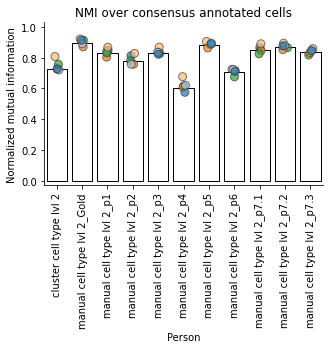

In [249]:
fig, axs = plt.subplots(1,1, sharey=False)
p0 = sns.barplot(x=df_nmi05['Person'], y=df_nmi05['NMI'], edgecolor='k', color='white', ax=axs)

p3 = sns.stripplot(ax=axs, data =df_sample_nmi5, x='Person', y='NMI', hue='Sample',
              palette='tab20', size=8, dodge=False, linewidth=1, alpha=0.7)
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation=90)
axs.set_ylabel('Normalized mutual information')
axs.set_title('NMI over consensus annotated cells')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_ylim([-0.03,1.03])
axs.legend().remove()

plt.savefig(f'./../figures/{today}_gating_test_nmi_v5_level2.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_nmi_v5_level2.png', bbox_inches='tight')
plt.show()

## Compute cell type compositions

A primary readout of flow cytometry data is the cell type compositions per sample. Here we compute the compositions per sample after removal of debris cells.

In [250]:
anno_keys = [key for key in adata_con.obs_keys() if key.count('cell type lvl 1')>0]

In [252]:
anno_cells = adata_con.obs[anno_keys]

In [253]:
anno_cells['sample']=adata_con.obs['sample'].cat.codes

/tmp/ipykernel_379030/3006737827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_cells['sample']=adata_con.obs['sample'].cat.codes


In [255]:
ct_comp_lvl1 = dict()
for key in anno_keys:
    tmp = pd.crosstab(anno_cells[key][anno_cells[key]!='not annotated'], 
                                   [ 'composition',anno_cells['sample']], normalize=1)*100
    tmp = tmp.unstack().reset_index()
    tmp.drop('col_0',axis=1, inplace=True)
    tmp.insert(0, "Person", np.repeat(key, tmp.shape[0]))
    tmp.rename({0 : 'composition', key: 'cell type label level 1'}, axis=1, inplace=True)
    ct_comp_lvl1[key] = tmp

In [256]:
df_comp1 = pd.concat(ct_comp_lvl1, ignore_index=True)

In [257]:
df_comp1['cell type label level 1'] = df_comp1['cell type label level 1'].cat.remove_unused_categories()

In [258]:
sub = df_comp1[df_comp1['Person']=='cluster cell type lvl 1']
gold = df_comp1[df_comp1['Person']=='manual cell type lvl 1_Gold']

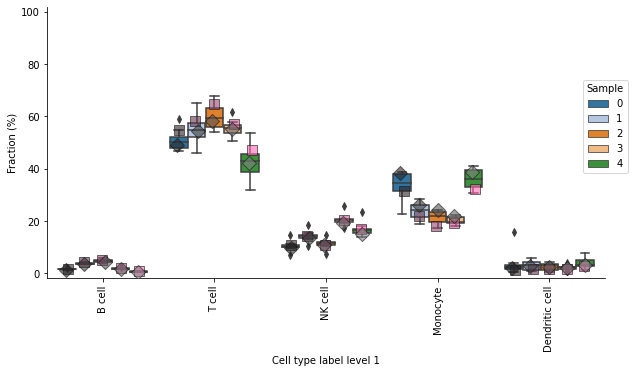

In [275]:
fig = plt.figure(figsize=(10,5))
p7 = sns.boxplot(data =df_comp1, x='cell type label level 1',
                 y='composition', hue='sample', palette='tab20', 
                )
sns.stripplot(ax=p7,data =sub, x='cell type label level 1', y='composition', hue='sample',
              color='hotpink',
              #palette='tab20',
              size=10, dodge=True, marker='s', linewidth=1, alpha=0.6
             )
sns.stripplot(ax=p7,data =gold, x='cell type label level 1', y='composition', hue='sample',
              color='grey',
              #palette='tab20',
              size=10, dodge=True, marker='D', linewidth=1, alpha=0.6
             )
handles, labels = p7.get_legend_handles_labels()
p7.legend(handles = handles[:5],labels = labels[:5],bbox_to_anchor=(1.05,0.75), title='Sample')

p7.set_xlabel('Cell type label level 1')
p7.set_ylabel('Fraction (%)')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([-2, 102])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_compositions.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_compositions.png', bbox_inches='tight')
plt.show()

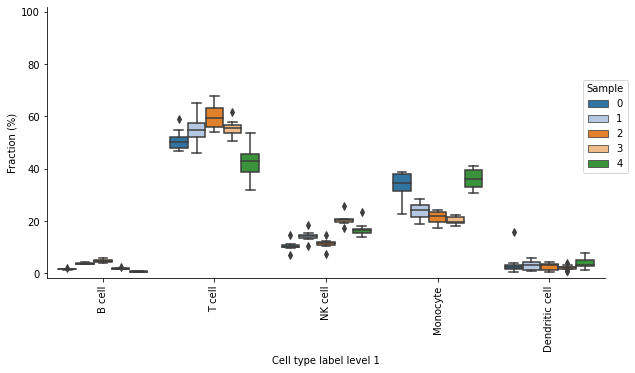

In [288]:
fig = plt.figure(figsize=(10,5))
p7 = sns.boxplot(data =df_comp1, x='cell type label level 1', y='composition', hue='sample', palette='tab20', 
                )
handles, labels = p7.get_legend_handles_labels()
p7.legend(handles = handles[:5],labels = labels[:5],bbox_to_anchor=(1.05,0.75), title='Sample')

p7.set_xlabel('Cell type label level 1')
p7.set_ylabel('Fraction (%)')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([-2, 102])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_compositions_clean.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_compositions_clean.png', bbox_inches='tight')
plt.show()

In [279]:
df_concat = pd.concat([gold, sub])

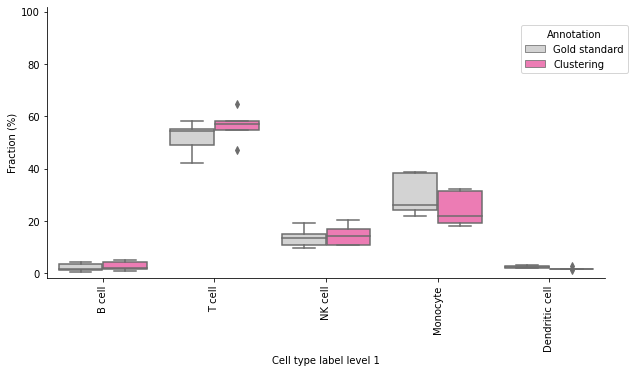

In [326]:
fig = plt.figure(figsize=(10,5))
p7 = sns.boxplot(data =df_concat, x='cell type label level 1', y='composition', hue='Person', 
                 palette=['lightgrey', 'hotpink'] 
                )
handles, labels = p7.get_legend_handles_labels()
p7.legend(handles = handles[:2],labels = ['Gold standard', 'Clustering'],
          bbox_to_anchor=(1.05,0.95), title='Annotation')

p7.set_xlabel('Cell type label level 1')
p7.set_ylabel('Fraction (%)')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([-2, 102])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_compositions_comparison.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_compositions_comparison.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_379030/563249123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_ct['cell type label level 1'] = df_concat_ct['cell type label level 1'].cat.remove_unused_categories()
/tmp/ipykernel_379030/563249123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_ct['cell type label level 1'] = df_concat_ct['cell type label level 1'].cat.remove_unused_categories()
/tmp/ipykernel_379030/563249123.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax

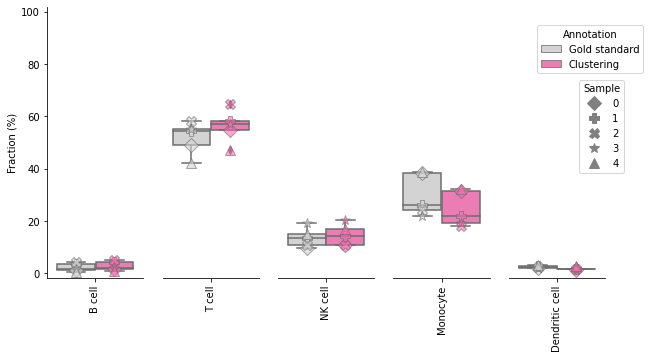

In [372]:
fig,axs = plt.subplots(ncols = len(cell_types), figsize=(10,5))

markers = ['D', 'P', 'X', '*', '^']
cell_types = df_concat['cell type label level 1'].unique()

for idx, val in enumerate(cell_types):
    df_concat_ct = df_concat.loc[df_concat['cell type label level 1']== val]
    df_concat_ct['cell type label level 1'] = df_concat_ct['cell type label level 1'].cat.remove_unused_categories()
    p7 = sns.boxplot(data=df_concat_ct, 
                     x='cell type label level 1', 
                     y='composition', hue='Person', 
                     palette=['lightgrey', 'hotpink'],
                     ax=axs[idx] 
                )

    for idx2, sample in enumerate(df_concat_ct['sample'].unique()):
        p8 = sns.swarmplot(data =df_concat_ct.loc[df_concat_ct['sample']==sample], 
                           x='cell type label level 1', y='composition', hue='Person', 
              size=10, dodge=True, marker=markers[idx2], linewidth=1, alpha=0.6,
              palette=['lightgrey', 'hotpink'], 
              ax=axs[idx] )
    
    if idx<len(cell_types)-1:
        axs[idx].get_legend().remove()
    if idx==0:
        axs[idx].set_ylabel('Fraction (%)')
    else:
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('')
        axs[idx].set_yticklabels(np.repeat('', len(axs[idx].get_yticklabels())))
        axs[idx].tick_params(left=False)
        axs[idx].spines['left'].set_visible(False)
        #axs[idx].spines['right'].set_visible(False)
    
    axs[idx].set_xlabel('')
    axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=90)
    axs[idx].set_ylim([-2, 102])
    axs[idx].spines['top'].set_visible(False)
    axs[idx].spines['right'].set_visible(False)
    
        
handles, labels = p7.get_legend_handles_labels()
leg = axs[idx].legend(handles = handles[:2],labels = ['Gold standard', 'Clustering'],
          bbox_to_anchor=(1.45,0.95), title='Annotation')
axs[idx].add_artist(leg)
h=[plt.plot([],[], color='grey', marker=marker,ms=10, ls="" )[0] for marker in markers]
plt.legend(handles=h, title='Sample', labels=range(len(df_concat['sample'].unique())), bbox_to_anchor=(1.25,0.75))

plt.savefig(f'./../figures/{today}_gating_test_compositions_comparison_paired.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_compositions_comparison_paired.png', bbox_inches='tight')
plt.show()

Level 2:

In [260]:
anno_keys2 = [key for key in adata_con.obs_keys() if key.count('cell type lvl 2')>0]

In [262]:
anno_cells2 = adata_con.obs[anno_keys2]

In [263]:
anno_cells2.head()

,cluster cell type lvl 2,manual cell type lvl 2_Gold,manual cell type lvl 2_p1,manual cell type lvl 2_p2,manual cell type lvl 2_p3,manual cell type lvl 2_p4,manual cell type lvl 2_p5,manual cell type lvl 2_p6,manual cell type lvl 2_p7.1,manual cell type lvl 2_p7.2,manual cell type lvl 2_p7.3
0-0,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated
1-0,CD8+ T cell,CD8+ T cell,T cell,T cell,CD8+ T cell,not annotated,CD8+ T cell,CD8+ T cell,CD8+ T cell,CD8+ T cell,CD8+ T cell
2-0,NK cell,NK cell,NK cell,NK cell,NK cell,not annotated,NK cell,NK cell,NK cell,NK cell,NK cell
3-0,not annotated,Classical monocyte,Classical monocyte,Classical monocyte,cDC,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte
4-0,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell


In [264]:
ct_comp_lvl2 = dict()
for key in anno_keys2:
    tmp = pd.crosstab(anno_cells2[key][anno_cells2[key]!='not annotated'], 
                                   [ 'composition',anno_cells['sample']], normalize=1)*100
    tmp = tmp.unstack().reset_index()
    tmp.drop('col_0',axis=1, inplace=True)
    tmp.insert(0, "Person", np.repeat(key, tmp.shape[0]))
    tmp.rename({0 : 'composition', key: 'cell type label level 2'}, axis=1, inplace=True)
    ct_comp_lvl2[key] = tmp

In [265]:
df_comp2 = pd.concat(ct_comp_lvl2, ignore_index=True)

In [266]:
df_comp2['cell type label level 2'] = df_comp2['cell type label level 2'].astype('category')

In [373]:
df_comp2['cell type label level 2'] = df_comp2['cell type label level 2'].cat.reorder_categories([
    'B cell',
    'T cell',
    'CD4+ T cell', 
    'CD8+ T cell',
         'NKT cell','NK cell',
     'Monocyte',
        'Classical monocyte',  'Intermediate monocyte','Non-classical monocyte',
       'Dendritic cell', 'cDC', 'pDC',  
        ])

In [374]:
sub2 = df_comp2[df_comp2['Person']=='cluster cell type lvl 2']
gold2 = df_comp2[df_comp2['Person']=='manual cell type lvl 2_Gold']

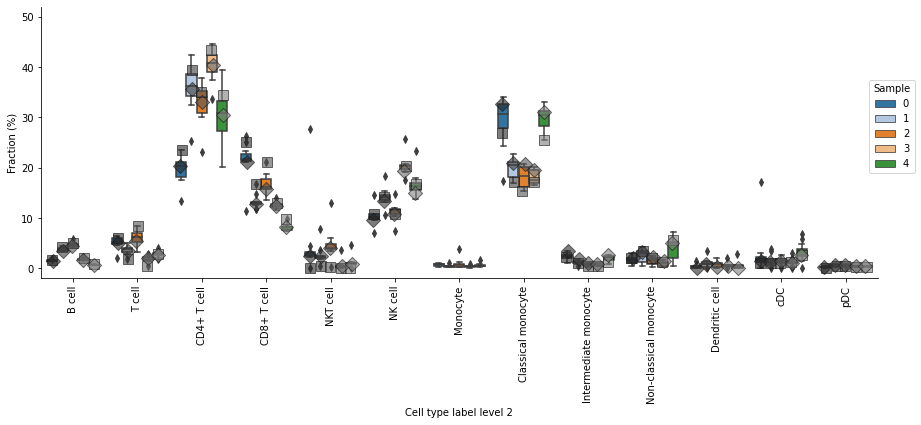

In [375]:
fig = plt.figure(figsize=(15,5))
p7 = sns.boxplot(data =df_comp2, x='cell type label level 2', y='composition', hue='sample', palette='tab20')
sns.stripplot(ax=p7,data =sub2, x='cell type label level 2', y='composition', hue='sample',
              color='grey',
              #palette='tab20',
              size=10, dodge=True, marker='s', linewidth=1, alpha=0.6)
sns.stripplot(ax=p7,data =gold2, x='cell type label level 2', y='composition', hue='sample',
              color='grey',
              #palette='tab20', 
              size=10, dodge=True,marker='D', linewidth=1, alpha=0.6)
handles, labels = p7.get_legend_handles_labels()
p7.legend(handles = handles[:5],labels = labels[:5],bbox_to_anchor=(1.05,0.75), title='Sample')

p7.set_xlabel('Cell type label level 2')
p7.set_ylabel('Fraction (%)')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([-2, 52])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_compositions_level2.png', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_compositions_level2.pdf', bbox_inches='tight')
plt.show()

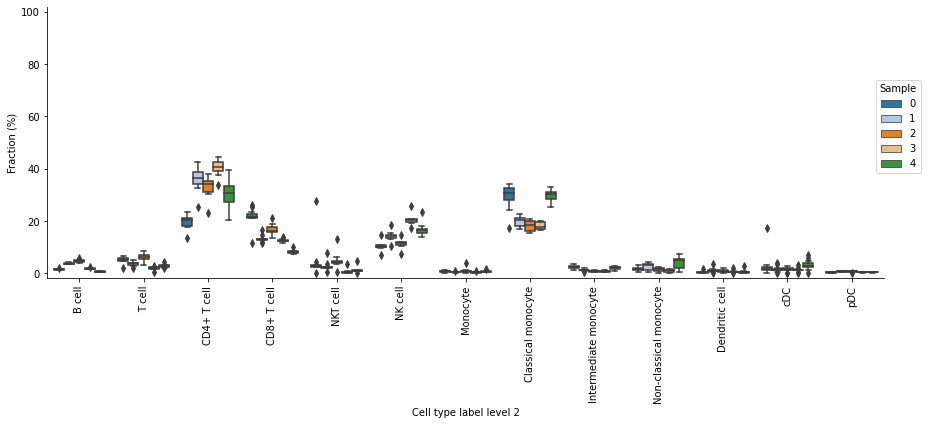

In [378]:
fig = plt.figure(figsize=(15,5))
p7 = sns.boxplot(data =df_comp2, x='cell type label level 2', y='composition', hue='sample', palette='tab20', 
                )
handles, labels = p7.get_legend_handles_labels()
p7.legend(handles = handles[:5],labels = labels[:5],bbox_to_anchor=(1.05,0.75), title='Sample')

p7.set_xlabel('Cell type label level 2')
p7.set_ylabel('Fraction (%)')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([-2, 102])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_compositions_level2_clean.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_compositions_level2_clean.png', bbox_inches='tight')
plt.show()

In [379]:
df_concat2 = pd.concat([gold2, sub2])

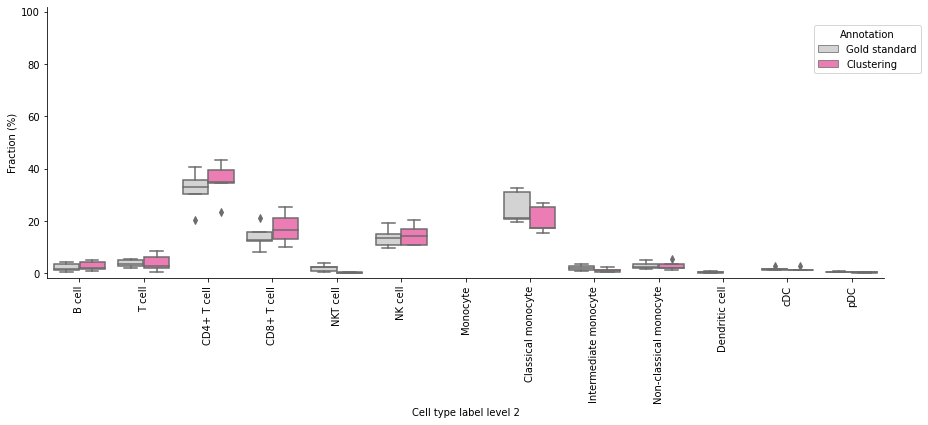

In [380]:
fig = plt.figure(figsize=(15,5))
p7 = sns.boxplot(data =df_concat2, x='cell type label level 2', y='composition', hue='Person', 
                 palette=['lightgrey', 'hotpink'] 
                )
handles, labels = p7.get_legend_handles_labels()
p7.legend(handles = handles[:2],labels = ['Gold standard', 'Clustering'],
          bbox_to_anchor=(1.05,0.95), title='Annotation')

p7.set_xlabel('Cell type label level 2')
p7.set_ylabel('Fraction (%)')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([-2, 102])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_compositions_level2_comparison.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_compositions_level2_comparison.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_379030/2375961110.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_ct['cell type label level 2'] = df_concat_ct['cell type label level 2'].cat.remove_unused_categories()
/tmp/ipykernel_379030/2375961110.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_ct['cell type label level 2'] = df_concat_ct['cell type label level 2'].cat.remove_unused_categories()
/tmp/ipykernel_379030/2375961110.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
 

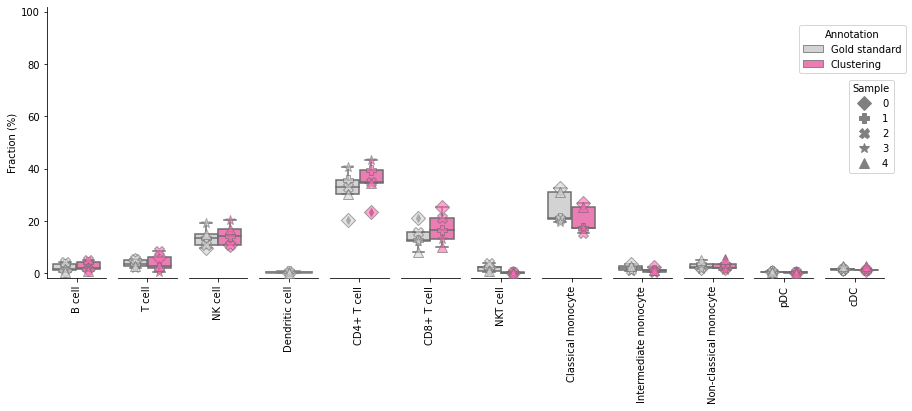

In [385]:
fig,axs = plt.subplots(ncols = len(cell_types), figsize=(15,5))

markers = ['D', 'P', 'X', '*', '^']
cell_types = df_concat2['cell type label level 2'].unique()

for idx, val in enumerate(cell_types):
    df_concat_ct = df_concat2.loc[df_concat2['cell type label level 2']== val]
    df_concat_ct['cell type label level 2'] = df_concat_ct['cell type label level 2'].cat.remove_unused_categories()
    p7 = sns.boxplot(data=df_concat_ct, 
                     x='cell type label level 2', 
                     y='composition', hue='Person', 
                     palette=['lightgrey', 'hotpink'],
                     ax=axs[idx] 
                )

    for idx2, sample in enumerate(df_concat_ct['sample'].unique()):
        p8 = sns.swarmplot(data =df_concat_ct.loc[df_concat_ct['sample']==sample], 
                           x='cell type label level 2', y='composition', hue='Person', 
              size=10, dodge=True, marker=markers[idx2], linewidth=1, alpha=0.6,
              palette=['lightgrey', 'hotpink'], 
              ax=axs[idx] )
    
    if idx<len(cell_types)-1:
        axs[idx].get_legend().remove()
    if idx==0:
        axs[idx].set_ylabel('Fraction (%)')
    else:
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('')
        axs[idx].set_yticklabels(np.repeat('', len(axs[idx].get_yticklabels())))
        axs[idx].tick_params(left=False)
        axs[idx].spines['left'].set_visible(False)
        #axs[idx].spines['right'].set_visible(False)
    
    axs[idx].set_xlabel('')
    axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=90)
    axs[idx].set_ylim([-2, 102])
    axs[idx].spines['top'].set_visible(False)
    axs[idx].spines['right'].set_visible(False)
    
        
handles, labels = p7.get_legend_handles_labels()
leg = axs[idx].legend(handles = handles[:2],labels = ['Gold standard', 'Clustering'],
          bbox_to_anchor=(1.45,0.95), title='Annotation')
axs[idx].add_artist(leg)
h=[plt.plot([],[], color='grey', marker=marker,ms=10, ls="" )[0] for marker in markers]
plt.legend(handles=h, title='Sample', labels=range(len(df_concat['sample'].unique())), bbox_to_anchor=(1.25,0.75))

plt.savefig(f'./../figures/{today}_gating_test_compositions_level2_comparison_paired.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_compositions_level2_comparison_paired.png', bbox_inches='tight')
plt.show()

### Dispersion over mean per cell type

Next, we want to examine the dispersion over the mean. For this purpose, we use the normalized compositions and compute the variance/mean. The rationale is that if we do not correct for the total number of cells per sample, we introduce bias that depends on the total number of annotated cells.   

Compute variance and mean per cell type and sample.

In [386]:
dispersion = df_comp1.groupby(['cell type label level 1', 'sample']).agg(
    ['var','mean', lambda x: np.var(x)/np.mean(x)])

Get cell type order according to the consensus label.

In [387]:
ct_order = dfi0['consensus label'].value_counts().index.values

In [388]:
ct_order = ct_order[ct_order != 'not annotated']

In [389]:
disp_long = dispersion['composition'].reset_index()
disp_long['cell type label level 1']= pd.Categorical(disp_long['cell type label level 1'],
                                        categories=ct_order)

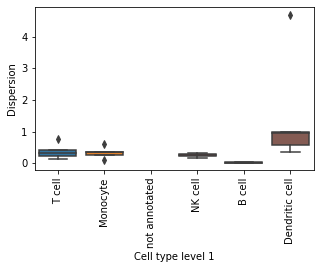

In [390]:
p10 = sns.boxplot(data=disp_long, x='cell type label level 1', y='<lambda_0>', 
                       )
p10.set_ylabel('Dispersion')
p10.set_xlabel('Cell type level 1')
p10.set_xticklabels(p10.get_xticklabels(), rotation=90)
plt.savefig(f'./../figures/{today}_gating_test_dispersion_level1.pdf', bbox_inches='tight')
plt.savefig(f'./../figures/{today}_gating_test_dispersion_level1.png', bbox_inches='tight')
plt.show()

In [391]:
dispersion = df_comp2.groupby(['cell type label level 2', 'sample']).agg(
    ['var','mean', lambda x: np.var(x)/np.mean(x)])

Get cell type order according to the consensus label.

In [392]:
ct_order = dfi02['consensus label'].value_counts().index.values

In [393]:
ct_order = ct_order[ct_order != 'not annotated']

In [394]:
disp_long = dispersion['composition'].reset_index()
disp_long['cell type label level 2']= pd.Categorical(disp_long['cell type label level 2'],
                                        categories=ct_order)

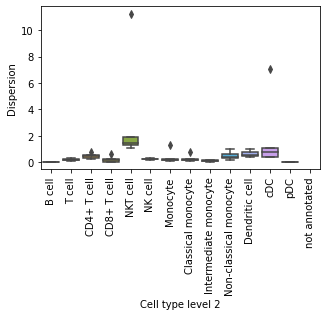

In [395]:
p10 = sns.boxplot(data=disp_long, x='cell type label level 2', y='<lambda_0>', 
                       )
p10.set_ylabel('Dispersion')
p10.set_xticklabels(p10.get_xticklabels(), rotation=90)
p10.set_xlabel('Cell type level 2')
plt.show()

End of the notebook.